In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy import feature as cfeature
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE, OCEAN, LAKES, BORDERS
import matplotlib.ticker as mticker

# Using the Updated PINT data to group over average locations
The updated PINT data used is PINT v8.0.0 and can be found: |http://www.pintdb.org

In [2]:
pint_upd = pd.read_excel('..\..\data\S1_PINT_QPI.xlsx')    # import data

In [3]:
pint_upd.columns

Index(['UID', 'OLD_DATA', 'REF', 'IDENT', 'SLAT', 'SLONG', 'AGE', 'DAGE',
       'AGEMTD', 'CONTINENT', 'REPLOC', 'INTM', 'P', 'NDIR', 'INC', 'DEC', 'K',
       'A95', 'NINT', 'B', 'DB', 'DB%', 'DBN (%)', 'VDM/VADM', 'VDM', 'VADM',
       'GROUP', 'TYPE', 'FORM', 'ROCKMAG', 'COMMENTS', 'LOCATION NAME', 'QAGE',
       'QSTAT', 'QTRM', 'QALT', 'QMD', 'QACN', 'QTECH', 'QLITH', 'QMAG',
       'QDIR', 'QPI'],
      dtype='object')

In [4]:
# drop the columns not going to be used 

pint_upd.drop(['OLD_DATA', 'REF', 'IDENT','AGEMTD', 'CONTINENT', 'REPLOC','INTM', 'A95', 'DB%', 'DBN (%)', 'GROUP', 'TYPE', 'FORM', 'ROCKMAG', 'COMMENTS', 'LOCATION NAME', 'QAGE',
       'QSTAT', 'QTRM', 'QALT', 'QMD', 'QACN', 'QTECH', 'QLITH', 'QMAG', 'QDIR'], axis=1, inplace=True)

### Sorting and Auditing the data

In [5]:
# sort for ages 0-5 Ma and Normal polarity 

pint05 = pint_upd.loc[ (pint_upd.AGE <= 5.00) & (pint_upd.P == 'N') ]

In [6]:
pint_05 = pint05.sort_values(by='SLAT') # sort by increasing Latitude values
pint_05.reset_index(inplace=True) #reset index column
pint_05

,index,UID,SLAT,SLONG,AGE,DAGE,P,NDIR,INC,DEC,K,NINT,B,DB,VDM/VADM,VDM,VADM,QPI
0,3200,3212,-78.40000,164.21000,1.1800,0.0200,N,7.0,-78.0,296.6,224.0,1.0,46.3,NaN,NaN,6.362853,NaN,4.0
1,3188,3200,-78.39000,164.21000,0.0840,0.0080,N,7.0,-85.9,264.3,178.0,2.0,27.2,1.7,NaN,3.543778,NaN,4.0
2,3189,3201,-78.39000,164.23000,0.1200,0.0200,N,8.0,-84.2,293.9,280.0,4.0,26.0,2.9,NaN,3.412865,NaN,4.0
3,3190,3202,-78.39000,164.27000,0.1200,0.0200,N,7.0,-82.8,344.7,160.0,3.0,25.4,3.5,NaN,3.360670,NaN,5.0
4,3199,3211,-78.39000,164.27000,1.1800,0.0200,N,8.0,-82.0,280.1,319.0,1.0,26.5,NaN,NaN,3.524549,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,3739,3751,66.10000,342.80000,0.7800,0.0400,N,6.0,73.8,11.2,1323.0,1.0,33.8,NaN,NaN,4.853785,NaN,4.0
1095,3774,3786,70.84644,9.03706,0.2925,0.0216,N,7.0,64.7,65.4,550.0,4.0,30.4,3.6,NaN,4.890333,NaN,4.0
1096,3771,3783,70.88377,8.79582,0.1438,0.0150,N,8.0,72.3,27.8,619.0,3.0,62.5,2.9,NaN,9.133152,NaN,4.0
1097,3772,3784,70.91960,8.71604,0.2300,0.2300,N,9.0,75.5,61.8,237.0,2.0,48.2,0.6,NaN,6.792990,NaN,4.0


In [7]:
# drop any NANs in the B column
pint_05.dropna(subset=['B'])
print('Original length of PINT Sorted for 5 MA: ', len(pint05))
print('New length of PINT Sorted for 5 MA: ', len(pint_05))      # these should be equal if there are no NANs in the B column

Original length of PINT Sorted for 5 MA:  1099
New length of PINT Sorted for 5 MA:  1099


### Clustering the Data over locations to produce groups of locations that are within 10 degrees every other point in the group

Calculate individual cartesian coordinates and VADM and VDM

In [8]:
latr = np.radians(pint_05.SLAT)   
longr = np.radians(pint_05.SLONG)  #converts Lat and Long values into radians

# create cartesian coordinates columns
pint_05['X']= np.cos(latr)*np.cos(longr)  #convert Lat and Long to cartesian X,Y,Z coordinates and creates X, Y, and Z columns 
pint_05['Y']= np.cos(latr)*np.sin(longr)
pint_05['Z']= np.sin(latr)

decr = np.radians(pint_05.DEC)                          # converts Dec and Inc degree values into radians
incr = np.radians(pint_05.INC)

# create dec/inc cartesian coords columns
pint_05['X2']= np.cos(incr)*np.cos(decr)                # convert dec and inc to cartesian X,Y,Z coordinates and creates X2, Y2, and Z2 columns 
pint_05['Y2']= np.cos(incr)*np.sin(decr)
pint_05['Z2']= np.sin(incr)

pint_05

,index,UID,SLAT,SLONG,AGE,DAGE,P,NDIR,INC,DEC,...,VDM/VADM,VDM,VADM,QPI,X,Y,Z,X2,Y2,Z2
0,3200,3212,-78.40000,164.21000,1.1800,0.0200,N,7.0,-78.0,296.6,...,NaN,6.362853,NaN,4.0,-0.193490,0.054716,-0.979575,0.093094,-0.185905,-0.978148
1,3188,3200,-78.39000,164.21000,0.0840,0.0080,N,7.0,-85.9,264.3,...,NaN,3.543778,NaN,4.0,-0.193655,0.054762,-0.979540,-0.007101,-0.071144,-0.997441
2,3189,3201,-78.39000,164.23000,0.1200,0.0200,N,8.0,-84.2,293.9,...,NaN,3.412865,NaN,4.0,-0.193674,0.054695,-0.979540,0.040942,-0.092391,-0.994881
3,3190,3202,-78.39000,164.27000,0.1200,0.0200,N,7.0,-82.8,344.7,...,NaN,3.360670,NaN,5.0,-0.193712,0.054559,-0.979540,0.120891,-0.033072,-0.992115
4,3199,3211,-78.39000,164.27000,1.1800,0.0200,N,8.0,-82.0,280.1,...,NaN,3.524549,NaN,4.0,-0.193712,0.054559,-0.979540,0.024406,-0.137016,-0.990268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,3739,3751,66.10000,342.80000,0.7800,0.0400,N,6.0,73.8,11.2,...,NaN,4.853785,NaN,4.0,0.387023,-0.119804,0.914254,0.273678,0.054190,0.960294
1095,3774,3786,70.84644,9.03706,0.2925,0.0216,N,7.0,64.7,65.4,...,NaN,4.890333,NaN,4.0,0.324028,0.051536,0.944643,0.177901,0.388569,0.904083
1096,3771,3783,70.88377,8.79582,0.1438,0.0150,N,8.0,72.3,27.8,...,NaN,9.133152,NaN,4.0,0.323634,0.050077,0.944856,0.268942,0.141797,0.952661
1097,3772,3784,70.91960,8.71604,0.2300,0.2300,N,9.0,75.5,61.8,...,NaN,6.792990,NaN,4.0,0.323119,0.049537,0.945061,0.118317,0.220661,0.968148


In [9]:
df = pint_05.iloc[:]             # copy table to a new one as to not revert previous setting on table

In [10]:
# calculate VADM 
t = np.radians(90 - df['SLAT'])
f = df['B']/10**6
r = 6.3781*10 ** 6          # Earth radius
mu = 4*np.pi*10 ** -7
I = np.radians(df['INC'])
t_m = np.arctan(np.tan(np.tan(I)/2))

# createVADM column
df["VADMCalculated"] = ((f/(np.sqrt(1+3*(np.cos(t)) ** 2)))*((4*np.pi*r ** 3)/mu))/10**22    # units =ZAm^2

# calculate and create VDM column
df["VDMCalculated"] = (f*(4*np.pi*r**3)*(np.sqrt(1+3*(np.cos(I))**2))/(2*mu))/10**22

In [11]:
df

,index,UID,SLAT,SLONG,AGE,DAGE,P,NDIR,INC,DEC,...,VADM,QPI,X,Y,Z,X2,Y2,Z2,VADMCalculated,VDMCalculated
0,3200,3212,-78.40000,164.21000,1.1800,0.0200,N,7.0,-78.0,296.6,...,NaN,4.0,-0.193490,0.054716,-0.979575,0.093094,-0.185905,-0.978148,6.099745,6.384149
1,3188,3200,-78.39000,164.21000,0.0840,0.0080,N,7.0,-85.9,264.3,...,NaN,4.0,-0.193655,0.054762,-0.979540,-0.007101,-0.071144,-0.997441,3.583531,3.555639
2,3189,3201,-78.39000,164.23000,0.1200,0.0200,N,8.0,-84.2,293.9,...,NaN,4.0,-0.193674,0.054695,-0.979540,0.040942,-0.092391,-0.994881,3.425434,3.424287
3,3190,3202,-78.39000,164.27000,0.1200,0.0200,N,7.0,-82.8,344.7,...,NaN,5.0,-0.193712,0.054559,-0.979540,0.120891,-0.033072,-0.992115,3.346386,3.371918
4,3199,3211,-78.39000,164.27000,1.1800,0.0200,N,8.0,-82.0,280.1,...,NaN,4.0,-0.193712,0.054559,-0.979540,0.024406,-0.137016,-0.990268,3.491308,3.536346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,3739,3751,66.10000,342.80000,0.7800,0.0400,N,6.0,73.8,11.2,...,NaN,4.0,0.387023,-0.119804,0.914254,0.273678,0.054190,0.960294,4.682597,4.870031
1095,3774,3786,70.84644,9.03706,0.2925,0.0216,N,7.0,64.7,65.4,...,NaN,4.0,0.324028,0.051536,0.944643,0.177901,0.388569,0.904083,4.113371,4.906701
1096,3771,3783,70.88377,8.79582,0.1438,0.0150,N,8.0,72.3,27.8,...,NaN,4.0,0.323634,0.050077,0.944856,0.268942,0.141797,0.952661,8.455374,9.163721
1097,3772,3784,70.91960,8.71604,0.2300,0.2300,N,9.0,75.5,61.8,...,NaN,4.0,0.323119,0.049537,0.945061,0.118317,0.220661,0.968148,6.519756,6.815726


pd.set_option('display.max_rows', 10)

 compare each row to check degree col
 if less than 10 degrees begin a group

degree = []
rowIndex =  0
X_col = df.columns.get_loc("X")
Z_col = df.columns.get_loc("Z")

for rowIndex in range(len(df)-1):     
    degree.append(calculate_degrees(df, X_col, Z_col, rowIndex, rowIndex + 1))

df["Degree"] = pd.Series(degree)

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df

In [12]:
vadm_global = np.average(df['VADMCalculated'])
print('Global Axial Dipole:', vadm_global)    # old 0-5 PINT GAD = 7.213

Global Axial Dipole: 7.087149971094785


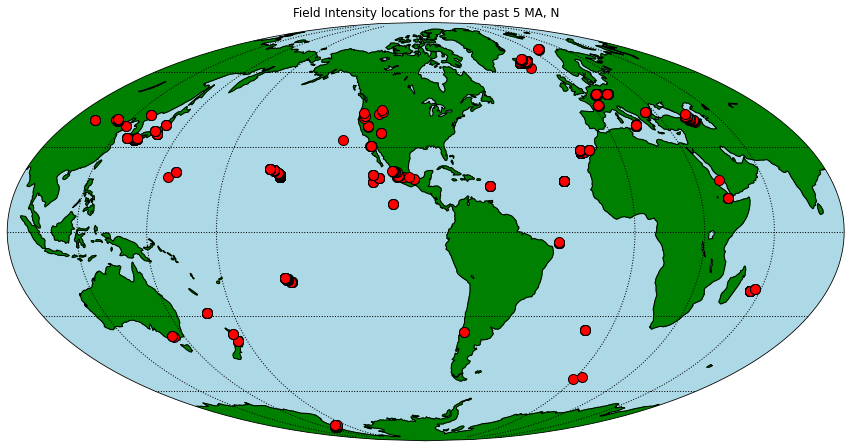

In [13]:
lons = df.SLONG.values
lats = df.SLAT.values

fig = plt.figure(figsize=(15,15))     # figure object

ax = plt.axes(projection=ccrs.Mollweide(central_longitude=-90.0))
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='black', linewidth=1, linestyle='dotted')
gl.top_labels = False
gl.ylocator = mticker.FixedLocator(np.arange(-90.0, 91.0, 30.0))
gl.xlocator = mticker.FixedLocator(np.arange(0.0, 400.0, 30.0));
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(OCEAN, color='lightblue')
ax.add_feature(LAND, color='green')
ax.add_feature(LAKES, facecolor='lightblue', edgecolor='black')

ax.plot([lons], [lats], marker='o', color='r',\
        markersize=10, transform=ccrs.Geodetic(), markeredgecolor='black')
ax.set_global()
ax.coastlines()

plt.title('Field Intensity locations for the past 5 MA, N');

In [14]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

In [15]:
def convertlat_colat(lat1, lat2):
    """ 
    Function to take latitudes in degrees and convert to colatitudes in radians
    
    Parameters:
    lat1, lat2: floats
        Input latitudes as floats. 
    Returns:
    colat1,colat2: floats
        The output colatitudes as floats. 
    """
    colat1, colat2 = 90 - lat1, 90 - lat2
    colat1r = np.radians(colat1)
    colat2r = np.radians(colat2)
    return colat1r, colat2r

def difference_two_lons(lon1, lon2):
    """ 
    Function to take 2 longitudes and calculate difference
    
    Parameters:
    lon1, lon2: floats
        Input longitudes as floats. 
    Returns:
    difference: float
        The difference between latitudes. 
    """
    lon_diff = lon1 - lon2
    
    return lon_diff   #degrees

def great_circle(lat1, lon1, lat2, lon2):
    """ 
    Calculate the distance, that is the great circle distance, between two points on a globe.
    
    Parameters:
    lat_1 : float
            Input latitude of first point  
    lon_1 : float
            Input longitude of first point
    lat_2 : float
            Input latitude of second point.
    lon_2 : float
            Input longitude of second point.
    Returns:
    a : float
        The great circle distance. 
    """
    colat1r, colat2r = convertlat_colat(lat1, lat2)    # 2 colats in rad 
    lon_diff = difference_two_lons(lon1, lon2) # diff in degrees
    alpha  = np.radians(lon_diff)
    
    cosa = np.cos(colat1r) * np.cos(colat2r) + np.sin(colat1r) * np.sin(colat2r) * np.cos(alpha)
    
    if 1 <= cosa <= 1.2: 
        cosa = 1
        
    a = np.arccos(cosa)
    return np.round(np.degrees(a), 1)

def distance(point_a, point_b):
    lat1 = point_a[0]
    lon1 = point_a[1]
    lat2 = point_b[0]
    lon2 = point_b[1]
    return great_circle(lat1, lon1, lat2, lon2)

def calculate_degrees(array_a, array_b):
    """
    This calculates the degrees between two arrays of cartesian coordinates. 
    
    Input: 
        array_a: First array of cartesian coordinates with the 3 values ordered from X,Y, to Z.
        array_b: Second array of cartesian coordinates with the 3 values ordered from X,Y, to Z
        
    Output: 
        A value in degrees representing the distance between array_a and array_b in polar coordinates.
    """
    
    a = array_a
    b = array_b
    d = (np.dot(a,b))
    
    if 1.000000 <= d <= 1.2:
        d = 1.00
        
    return np.degrees(np.arccos(d))

def sim_affinity(X):
    return pairwise_distances(X, metric=calculate_degrees)

In [16]:
x_col = df.columns.get_loc('X')          # calling X column by name from the df
z_col = df.columns.get_loc('Z')          # calling Z column by name from the df

input_cartesian = np.array(df.iloc[:, x_col:z_col+1])     # array of X, Y, and Z values

# clustering algorithim to output the best number of clusters with a threshold of 10 degrees for a cluster
agg_clustering = AgglomerativeClustering(affinity=sim_affinity, linkage='average', distance_threshold=10, n_clusters=None)

# fit the AgglomerativeClustering algorithim to the input cartesian coords
fit1= agg_clustering.fit(input_cartesian)

Apply fit to dataframe 

In [17]:
df['group#'] = fit1.labels_        # assign group numbers to respective columns

df

,index,UID,SLAT,SLONG,AGE,DAGE,P,NDIR,INC,DEC,...,QPI,X,Y,Z,X2,Y2,Z2,VADMCalculated,VDMCalculated,group#
0,3200,3212,-78.40000,164.21000,1.1800,0.0200,N,7.0,-78.0,296.6,...,4.0,-0.193490,0.054716,-0.979575,0.093094,-0.185905,-0.978148,6.099745,6.384149,19
1,3188,3200,-78.39000,164.21000,0.0840,0.0080,N,7.0,-85.9,264.3,...,4.0,-0.193655,0.054762,-0.979540,-0.007101,-0.071144,-0.997441,3.583531,3.555639,19
2,3189,3201,-78.39000,164.23000,0.1200,0.0200,N,8.0,-84.2,293.9,...,4.0,-0.193674,0.054695,-0.979540,0.040942,-0.092391,-0.994881,3.425434,3.424287,19
3,3190,3202,-78.39000,164.27000,0.1200,0.0200,N,7.0,-82.8,344.7,...,5.0,-0.193712,0.054559,-0.979540,0.120891,-0.033072,-0.992115,3.346386,3.371918,19
4,3199,3211,-78.39000,164.27000,1.1800,0.0200,N,8.0,-82.0,280.1,...,4.0,-0.193712,0.054559,-0.979540,0.024406,-0.137016,-0.990268,3.491308,3.536346,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,3739,3751,66.10000,342.80000,0.7800,0.0400,N,6.0,73.8,11.2,...,4.0,0.387023,-0.119804,0.914254,0.273678,0.054190,0.960294,4.682597,4.870031,5
1095,3774,3786,70.84644,9.03706,0.2925,0.0216,N,7.0,64.7,65.4,...,4.0,0.324028,0.051536,0.944643,0.177901,0.388569,0.904083,4.113371,4.906701,24
1096,3771,3783,70.88377,8.79582,0.1438,0.0150,N,8.0,72.3,27.8,...,4.0,0.323634,0.050077,0.944856,0.268942,0.141797,0.952661,8.455374,9.163721,24
1097,3772,3784,70.91960,8.71604,0.2300,0.2300,N,9.0,75.5,61.8,...,4.0,0.323119,0.049537,0.945061,0.118317,0.220661,0.968148,6.519756,6.815726,24


### Calculating averages over groups

In [18]:
groups = df['group#'].unique()

print('Total number of groups created:', len(groups))

Total number of groups created: 27


In [19]:
def calc_group_avgs(dataframe_group):
    """
    This takes calculates several average values for the groups, including: average latitude and longitude, 
    average intensity, standard deviation of the intensity, the amount of values in the group, the average VADM, the
    standard deviation of the VADM, the age range, and the age minimum.
    
    Input: 
        dataframe_group: Dataframe group that includes points that are within degrees of eachother with columns 
                         labeled "X", "Y", "Z", "B", "AGE", and "VADMCalculated"
        
    Output: 
        Updated input dataframe with calculated avgerages into columns titled: 'Lat_avg', 'Lon_avg', 'B_avg', 'B_stdv', 'GroupAmount', 'VADMCalc_avg', 
        'VADMCalc_stdv', 'AGE_range', and 'AGE_min'. 
    """
    
    # calculate average latitude and longitude for the group
    x = np.average(dataframe_group['X'])
    y = np.average(dataframe_group['Y'])
    z = np.average(dataframe_group['Z'])

    lt = np.degrees(np.arcsin(z))                                         # converts averaged cartesian location to latitude in degrees 
    lg = np.degrees(np.arctan2(y,x))                                      # converts averaged cartesian location to longitude in degrees      

    dataframe_group['Lat_avg'] = lt 
    dataframe_group['Lon_avg'] = lg
    
    # calculates scalar Intensity average
    dataframe_group['B_avg'] = np.average(dataframe_group['B'])    # scalar avg B = B_avg 
    # calculates scalar standard deviation of Intensity
    dataframe_group['B_stdv'] = np.std(dataframe_group['B'])/np.sqrt(len(dataframe_group))       # scalar weighted stdv B = B_stdv
    
    # length of the group
    dataframe_group['GroupAmount'] = len(dataframe_group)
    
    # calculates the average expected VADM
    dataframe_group['VADMCalc_avg'] = np.average(dataframe_group['VADMCalculated']) 
    # calculates the weighted stdv of the VADM over the group
    dataframe_group['VADMCalc_stdv_w'] = np.std(dataframe_group['VADMCalculated'])/ np.sqrt(len(dataframe_group))
    # calculates the non-weighted stdv of the VADM over the group
    dataframe_group['VADMCalc_stdv_nw'] = np.std(dataframe_group['VADMCalculated'])

    # range of a group
    dataframe_group['AGE_range'] = (max(dataframe_group['AGE']) - min(dataframe_group['AGE']))
    dataframe_group['AGE_min'] = min(dataframe_group['AGE'])

In [20]:
groups_dataframes = []

for i in np.array(groups):                                       # for loop to step through each of the 27 group labels
    df_groupn = df.loc[df['group#'] == i]        # create a dataframe with just this group number 
    df_groupnc = df_groupn.copy()                                # make a copy of this selection of data

    calc_group_avgs(df_groupnc)                             # run my function to get the average values for the groups
    
    groups_dataframes.append(df_groupnc)

pint05ma_result = pd.concat(groups_dataframes, axis=0)           # collect individual group dataframes back into one dataframe 

In [21]:
pint05ma_result

,index,UID,SLAT,SLONG,AGE,DAGE,P,NDIR,INC,DEC,...,Lat_avg,Lon_avg,B_avg,B_stdv,GroupAmount,VADMCalc_avg,VADMCalc_stdv_w,VADMCalc_stdv_nw,AGE_range,AGE_min
0,3200,3212,-78.40000,164.21000,1.1800,0.0200,N,7.0,-78.0,296.6,...,-78.011847,165.072427,32.480000,3.146227,30,4.284487,0.415614,2.276409,2.2450,0.0550
1,3188,3200,-78.39000,164.21000,0.0840,0.0080,N,7.0,-85.9,264.3,...,-78.011847,165.072427,32.480000,3.146227,30,4.284487,0.415614,2.276409,2.2450,0.0550
2,3189,3201,-78.39000,164.23000,0.1200,0.0200,N,8.0,-84.2,293.9,...,-78.011847,165.072427,32.480000,3.146227,30,4.284487,0.415614,2.276409,2.2450,0.0550
3,3190,3202,-78.39000,164.27000,0.1200,0.0200,N,7.0,-82.8,344.7,...,-78.011847,165.072427,32.480000,3.146227,30,4.284487,0.415614,2.276409,2.2450,0.0550
4,3199,3211,-78.39000,164.27000,1.1800,0.0200,N,8.0,-82.0,280.1,...,-78.011847,165.072427,32.480000,3.146227,30,4.284487,0.415614,2.276409,2.2450,0.0550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,3739,3751,66.10000,342.80000,0.7800,0.0400,N,6.0,73.8,11.2,...,64.703960,-18.196808,46.893588,3.911366,65,6.546255,0.545555,4.398404,4.4395,0.0605
1095,3774,3786,70.84644,9.03706,0.2925,0.0216,N,7.0,64.7,65.4,...,70.909516,8.704069,52.425000,7.357341,4,7.091212,0.994669,1.989338,0.1487,0.1438
1096,3771,3783,70.88377,8.79582,0.1438,0.0150,N,8.0,72.3,27.8,...,70.909516,8.704069,52.425000,7.357341,4,7.091212,0.994669,1.989338,0.1487,0.1438
1097,3772,3784,70.91960,8.71604,0.2300,0.2300,N,9.0,75.5,61.8,...,70.909516,8.704069,52.425000,7.357341,4,7.091212,0.994669,1.989338,0.1487,0.1438


In [22]:
pint05ma_avgd = pint05ma_result[:]     # hard copy
pint05ma_avgd.columns                  # new columns

Index(['index', 'UID', 'SLAT', 'SLONG', 'AGE', 'DAGE', 'P', 'NDIR', 'INC',
       'DEC', 'K', 'NINT', 'B', 'DB', 'VDM/VADM', 'VDM', 'VADM', 'QPI', 'X',
       'Y', 'Z', 'X2', 'Y2', 'Z2', 'VADMCalculated', 'VDMCalculated', 'group#',
       'Lat_avg', 'Lon_avg', 'B_avg', 'B_stdv', 'GroupAmount', 'VADMCalc_avg',
       'VADMCalc_stdv_w', 'VADMCalc_stdv_nw', 'AGE_range', 'AGE_min'],
      dtype='object')

In [23]:
pint05ma_avgd['GroupLead'] = pint05ma_avgd['GroupAmount'].ne(pint05ma_avgd['GroupAmount'].shift(-1))      # create a row of T/F with first values of the groups

pint05ma_groups = pint05ma_avgd.loc[pint05ma_avgd.GroupLead == True]                                      # dataframe of rows that were the first of their groups
pint05ma_groups.drop(['index', 'UID', 'SLAT', 'SLONG', 'AGE', 'DAGE', 'P',              
       'NDIR', 'INC', 'DEC', 'K', 'NINT', 'B', 'DB', 'VDM/VADM', 'VDM', 'VADM',                           # drop columns with individual data information
       'X', 'Y', 'Z', 'VADMCalculated','VDMCalculated', 'GroupLead', 'QPI', 'X2', 'Y2', 'Z2'], axis=1, inplace=True)          
pd.set_option('display.max_rows', None)                                                                   # print all 27 rows

pint05ma_groups

C:\Users\trin\AppData\Local\Temp/ipykernel_10628/2914185332.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pint05ma_avgd['GroupLead'] = pint05ma_avgd['GroupAmount'].ne(pint05ma_avgd['GroupAmount'].shift(-1))      # create a row of T/F with first values of the groups
C:\Users\trin\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,group#,Lat_avg,Lon_avg,B_avg,B_stdv,GroupAmount,VADMCalc_avg,VADMCalc_stdv_w,VADMCalc_stdv_nw,AGE_range,AGE_min
29,19,-78.011847,165.072427,32.480000,3.146227,30,4.284487,0.415614,2.276409,2.245000,0.055000
31,8,-54.348510,1.269173,37.700000,2.687006,2,5.663969,0.392144,0.554576,0.150000,0.150000
45,16,-38.753965,175.455251,34.881818,4.181874,11,6.128801,0.731233,2.425227,0.153000,0.076000
43,17,-37.666607,144.199458,63.166667,2.787804,3,11.255789,0.497705,0.862051,0.000000,2.250000
47,13,-36.000000,-71.000000,39.150000,5.197235,2,7.118135,0.944946,1.336355,0.016000,0.784000
52,18,-35.083333,-12.283333,18.200000,2.659323,5,3.346585,0.488992,1.093419,0.025300,0.055450
59,25,-29.000000,167.800000,44.185714,3.700217,7,8.779671,0.735230,1.945237,0.000000,2.730000
119,11,-20.959899,55.590437,39.757750,1.497293,60,8.767541,0.329703,2.553865,1.777000,0.073000
165,12,-16.873026,-151.137151,20.128261,1.805465,46,4.669377,0.419720,2.846680,4.100000,0.510000
172,14,-3.858043,-32.429221,30.914286,3.772967,7,7.967016,0.972274,2.572395,0.000000,2.550000


### Mapping the groups

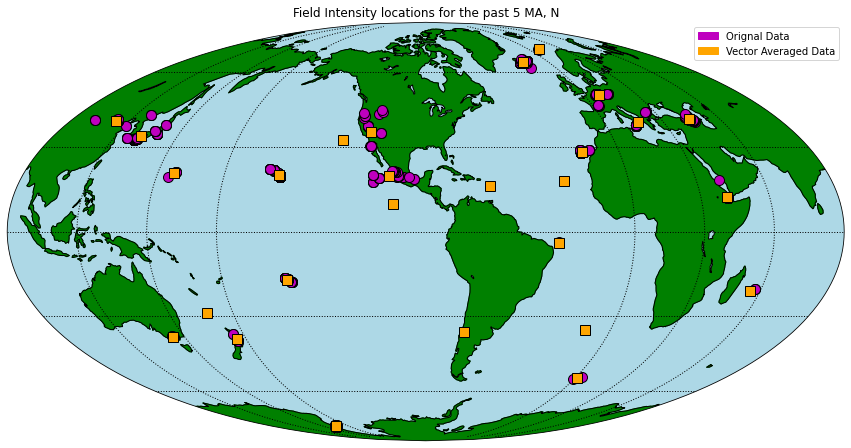

In [24]:
fig = plt.figure(figsize=(15,15))     # figure object

ax = plt.axes(projection=ccrs.Mollweide(central_longitude=-90.0))
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='black', linewidth=1, linestyle='dotted')
gl.top_labels = False
gl.ylocator = mticker.FixedLocator(np.arange(-90.0, 91.0, 30.0))
gl.xlocator = mticker.FixedLocator(np.arange(0.0, 400.0, 30.0));
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(OCEAN, color='lightblue')
ax.add_feature(LAND, color='green')
ax.add_feature(LAKES, facecolor='lightblue', edgecolor='black')

#original data
lons1 = df.SLONG.values
lats1 = df.SLAT.values

ax.plot([lons1], [lats1], marker='o', color='m',\
        markersize=10, transform=ccrs.Geodetic(), markeredgecolor='black', label='Original')
# vector averaged 
lons2 = pint05ma_groups.Lon_avg.values
lats2 = pint05ma_groups.Lat_avg.values

ax.plot([lons2], [lats2], marker='s', color='orange',\
        markersize=10, transform=ccrs.Geodetic(), markeredgecolor='black', label='Averaged')

# legend 
import matplotlib.patches as mpatches
Original = mpatches.Patch(color='m', label='Orignal Data')
VAverage = mpatches.Patch(color='orange', label='Vector Averaged Data')
plt.legend(handles=[Original, VAverage])

ax.set_global()
ax.coastlines()

plt.title('Field Intensity locations for the past 5 MA, N');

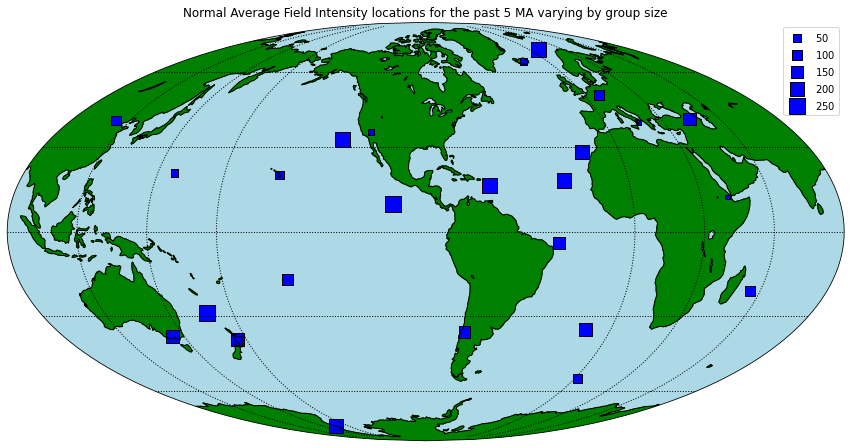

In [25]:
lons = pint05ma_groups['Lon_avg']
lats = pint05ma_groups['Lat_avg']

fig = plt.figure(figsize=(15,15))     # figure object

ax = plt.axes(projection=ccrs.Mollweide(central_longitude=-90.0))
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='black', linewidth=1, linestyle='dotted')
gl.top_labels = False
gl.ylocator = mticker.FixedLocator(np.arange(-90.0, 91.0, 30.0))
gl.xlocator = mticker.FixedLocator(np.arange(0.0, 400.0, 30.0));
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(OCEAN, color='lightblue')
ax.add_feature(LAND, color='green')
ax.add_feature(LAKES, facecolor='lightblue', edgecolor='black')

ax.set_global()
ax.coastlines()

# averaged 
sc = ax.scatter([lons], [lats], c='b', marker='s', transform=ccrs.Geodetic(),s=10*groups, edgecolors='k')    # square marker varying by the size of group
plt.legend(*sc.legend_elements("sizes", num=6, color='b',mec='k'))                                           # legened of marker size

plt.title('Normal Average Field Intensity locations for the past 5 MA varying by group size');

In [26]:
#pint05ma_result - dataframe with original data and avg
#pint05ma_groups - only avg data 
pint05ma_result.columns

Index(['index', 'UID', 'SLAT', 'SLONG', 'AGE', 'DAGE', 'P', 'NDIR', 'INC',
       'DEC', 'K', 'NINT', 'B', 'DB', 'VDM/VADM', 'VDM', 'VADM', 'QPI', 'X',
       'Y', 'Z', 'X2', 'Y2', 'Z2', 'VADMCalculated', 'VDMCalculated', 'group#',
       'Lat_avg', 'Lon_avg', 'B_avg', 'B_stdv', 'GroupAmount', 'VADMCalc_avg',
       'VADMCalc_stdv_w', 'VADMCalc_stdv_nw', 'AGE_range', 'AGE_min'],
      dtype='object')

### Checking the difference in degrees between each data point and the averaged location found for each group

In [27]:
def calculate_degrees(array_a, array_b):
    """
    This calculates the degrees between two arrays of cartesian coordinates. 
    
    Input: 
        array_a: First array of cartesian coordinates with the 3 values ordered from X, Y, to Z.
        array_b: Second array of cartesian coordinates with the 3 values ordered from X, Y, to Z
        
    Output: 
        A value in degrees representing the distance between array_a and array_b in polar coordinates.
    """
    
    a = array_a
    b = array_b
    d = (np.dot(a,b))
    
    if 1.000000 <= d <= 1.2:
        d = 1.00
        
    return np.arccos(d)

In [28]:
# for loop to calculate the degrees of one location from group average
# Find the Degrees from the calculated Avgerage location (avglat and avglong) for each data point 
# I am doing so by convertingto cartesian then taking the dot between the Original location and Avg location

lat_ravg = np.radians(pint05ma_result.Lat_avg.astype(float))
long_ravg = np.radians(pint05ma_result.Lat_avg.astype(float))

pint05ma_result['X_avg']= np.cos(lat_ravg)*np.cos(long_ravg)
pint05ma_result['Y_avg']= np.cos(lat_ravg)*np.sin(long_ravg)
pint05ma_result['Z_avg']= np.sin(lat_ravg)
 
X_a_col = pint05ma_result.columns.get_loc("X_avg")
Z_a_col = pint05ma_result.columns.get_loc("Z_avg")+1

X_col = pint05ma_result.columns.get_loc("X")
Z_col = pint05ma_result.columns.get_loc("Z")+1

cart_avgarr = pint05ma_result.iloc[:, X_a_col:Z_a_col].values   # array of all average X,Y,Z
cart_arr = pint05ma_result.iloc[:, X_col:Z_col].values          # array of all individual X,Y,Z

In [29]:
degreefa = []

for row in range(len(cart_avgarr)):
    a = (cart_arr[row,:])
    b = (cart_avgarr[row,:])
    
    deg = calculate_degrees(a,b)
    
    degreefa.append(deg)
    
#  degreefa fills in the 'DegreeFmAvg' column

pint05ma_result["Degree_fm_Avg"] = pd.Series(degreefa)        
pd.set_option('display.max_rows', 10)                                                                
pint05ma_result

,index,UID,SLAT,SLONG,AGE,DAGE,P,NDIR,INC,DEC,...,GroupAmount,VADMCalc_avg,VADMCalc_stdv_w,VADMCalc_stdv_nw,AGE_range,AGE_min,X_avg,Y_avg,Z_avg,Degree_fm_Avg
0,3200,3212,-78.40000,164.21000,1.1800,0.0200,N,7.0,-78.0,296.6,...,30,4.284487,0.415614,2.276409,2.2450,0.0550,0.043143,-0.203179,-0.978191,0.351822
1,3188,3200,-78.39000,164.21000,0.0840,0.0080,N,7.0,-85.9,264.3,...,30,4.284487,0.415614,2.276409,2.2450,0.0550,0.043143,-0.203179,-0.978191,0.351970
2,3189,3201,-78.39000,164.23000,0.1200,0.0200,N,8.0,-84.2,293.9,...,30,4.284487,0.415614,2.276409,2.2450,0.0550,0.043143,-0.203179,-0.978191,0.351932
3,3190,3202,-78.39000,164.27000,0.1200,0.0200,N,7.0,-82.8,344.7,...,30,4.284487,0.415614,2.276409,2.2450,0.0550,0.043143,-0.203179,-0.978191,0.351857
4,3199,3211,-78.39000,164.27000,1.1800,0.0200,N,8.0,-82.0,280.1,...,30,4.284487,0.415614,2.276409,2.2450,0.0550,0.043143,-0.203179,-0.978191,0.351857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,3739,3751,66.10000,342.80000,0.7800,0.0400,N,6.0,73.8,11.2,...,65,6.546255,0.545555,4.398404,4.4395,0.0605,0.182581,0.386323,0.904112,0.552970
1095,3774,3786,70.84644,9.03706,0.2925,0.0216,N,7.0,64.7,65.4,...,4,7.091212,0.994669,1.989338,0.1487,0.1438,0.106969,0.309074,0.945003,0.338422
1096,3771,3783,70.88377,8.79582,0.1438,0.0150,N,8.0,72.3,27.8,...,4,7.091212,0.994669,1.989338,0.1487,0.1438,0.106969,0.309074,0.945003,0.339298
1097,3772,3784,70.91960,8.71604,0.2300,0.2300,N,9.0,75.5,61.8,...,4,7.091212,0.994669,1.989338,0.1487,0.1438,0.106969,0.309074,0.945003,0.339384


### Plotting the averaged groups

In [30]:
avglats = pint05ma_groups.Lat_avg.values
avgB = pint05ma_groups.B_avg.values
avgB_stdv = pint05ma_groups.B_stdv.values
age_range = pint05ma_groups.AGE_range.values
age_min = pint05ma_groups.AGE_min.values

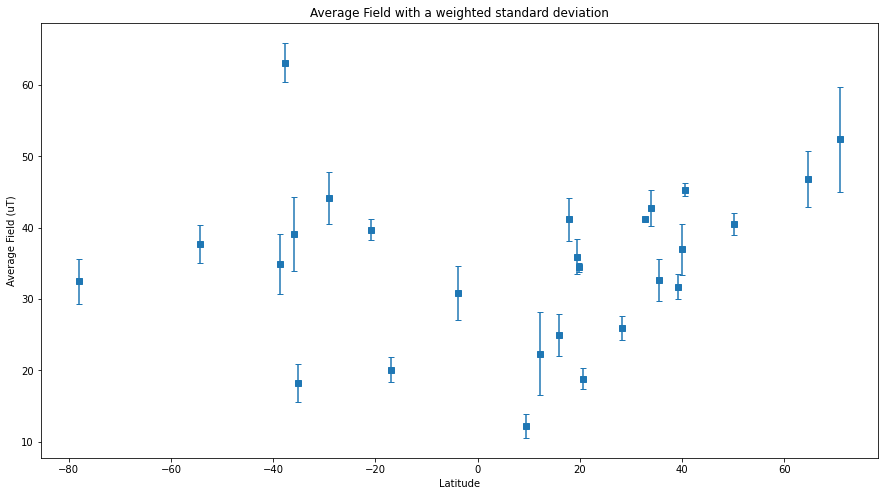

In [31]:
# Average Field values plot

plt.figure(figsize=(15, 8))

plt.xlabel('Latitude')
plt.ylabel('Average Field (uT)') 
plt.title('Average Field with a weighted standard deviation')

plt.errorbar(avglats, avgB, yerr = avgB_stdv, fmt = 's', capsize=3);

In [33]:
# VADM Plot
plt.figure(figsize=(14, 8))

# calculate actual VADM residual from expected
pint05ma_groups_W_res = pint05ma_groups[:]       # dataframe for groups with residual column added
vadmcalculatedcol = pint05ma_groups_W_res.iloc[:, pint05ma_groups_W_res.columns.get_loc("VADMCalc_avg")]
vadmglobal = np.average(vadmcalculatedcol) 
   
pint05ma_groups_W_res['Residual'] = pint05ma_groups_W_res["VADMCalc_avg"] - vadmglobal 
pint05ma_groups_W_res['Residual_stdv_nw'] = pint05ma_groups_W_res['Residual']/pint05ma_groups_W_res["VADMCalc_stdv_nw"] 
pint05ma_groups_W_res['Residual_stdv_w'] = pint05ma_groups_W_res['Residual']/pint05ma_groups_W_res["VADMCalc_stdv_w"] 
pint05ma_groups_W_res

C:\Users\trin\AppData\Local\Temp/ipykernel_10628/3699635500.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pint05ma_groups_W_res['Residual'] = pint05ma_groups_W_res["VADMCalc_avg"] - vadmglobal
C:\Users\trin\AppData\Local\Temp/ipykernel_10628/3699635500.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pint05ma_groups_W_res['Residual_stdv_nw'] = pint05ma_groups_W_res['Residual']/pint05ma_groups_W_res["VADMCalc_stdv_nw"]
C:\Users\trin\AppData\Local\Temp/ipykernel_10628/3699635500.py:11: SettingWithCo

,group#,Lat_avg,Lon_avg,B_avg,B_stdv,GroupAmount,VADMCalc_avg,VADMCalc_stdv_w,VADMCalc_stdv_nw,AGE_range,AGE_min,Residual,Residual_stdv_nw,Residual_stdv_w
29,19,-78.011847,165.072427,32.480000,3.146227,30,4.284487,0.415614,2.276409,2.2450,0.0550,-2.314920,-1.016917,-5.569886
31,8,-54.348510,1.269173,37.700000,2.687006,2,5.663969,0.392144,0.554576,0.1500,0.1500,-0.935439,-1.686765,-2.385446
45,16,-38.753965,175.455251,34.881818,4.181874,11,6.128801,0.731233,2.425227,0.1530,0.0760,-0.470607,-0.194046,-0.643579
43,17,-37.666607,144.199458,63.166667,2.787804,3,11.255789,0.497705,0.862051,0.0000,2.2500,4.656381,5.401517,9.355702
47,13,-36.000000,-71.000000,39.150000,5.197235,2,7.118135,0.944946,1.336355,0.0160,0.7840,0.518728,0.388166,0.548950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,9,39.920533,113.019213,36.960606,3.579441,33,6.415024,0.622189,3.574205,0.6320,0.0980,-0.184384,-0.051587,-0.296347
928,15,40.554556,44.571723,45.332787,0.887961,61,7.814097,0.155123,1.211547,3.6800,0.0500,1.214689,1.002593,7.830503
1029,10,50.138137,8.645783,40.579574,1.520818,90,6.324890,0.236343,2.242151,2.6500,0.0500,-0.274518,-0.122435,-1.161519
1094,5,64.703960,-18.196808,46.893588,3.911366,65,6.546255,0.545555,4.398404,4.4395,0.0605,-0.053152,-0.012084,-0.097428


<Figure size 1008x576 with 0 Axes>

In [34]:
# converting pandas df to text file 
np.savetxt(r'..\..\data\0tbl_PINT05_groups.txt', pint05ma_groups_W_res.values, fmt='%f')
#np.savetxt(r'..\..\data\0tbl_PINT05_groups.txt', pint05ma_groups_W_res.values, fmt='%d'  # to save without headings

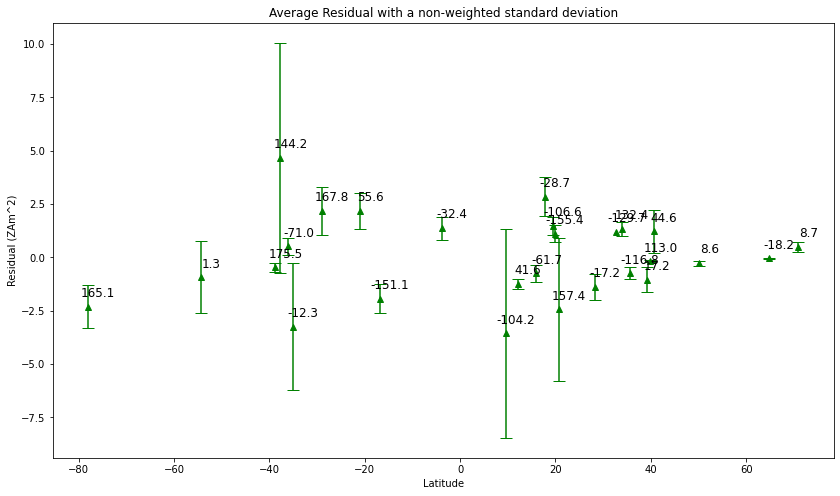

In [39]:
# plot residual w stdv bars for nw stdv vs lat
plt.figure(figsize=(14, 8))

residual = pint05ma_groups_W_res['Residual']
residual_stdv_nw = pint05ma_groups_W_res['Residual_stdv_nw']
plt.errorbar(avglats, residual, yerr = residual_stdv_nw, fmt = '^g', capsize=6, label='Non-weighted');

xs = avglats
ys = residual
ls = np.round(pd.to_numeric(pd.Series(pint05ma_groups["Lon_avg"])),1)

#zip joins x and y coordinates in pairs
for label, x, y in zip(ls, xs, ys):
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(10,10), ha = 'center', fontsize=12)
    
plt.xlabel('Latitude')
plt.ylabel('Residual (ZAm^2)') 
plt.title('Average Residual with a non-weighted standard deviation');

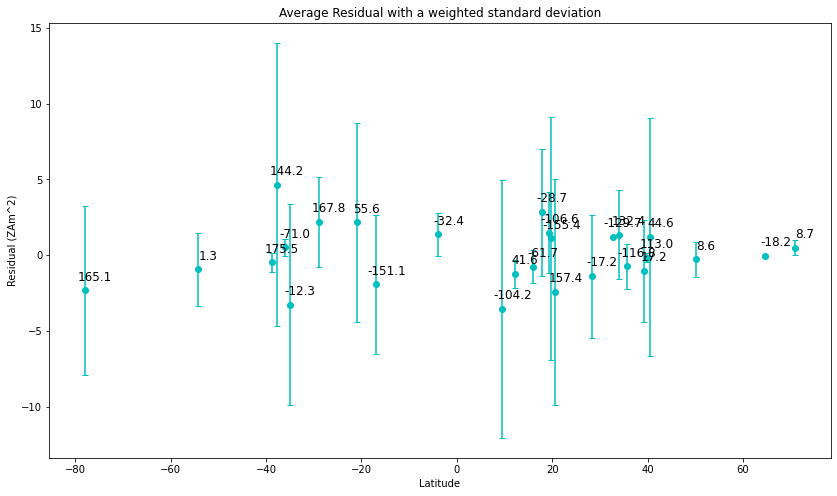

In [40]:
# plot residual vs lat
plt.figure(figsize=(14, 8))

plt.xlabel('Latitude')
plt.ylabel('Residual (ZAm^2)') 
plt.title('Average Residual with a weighted standard deviation')

residual_stdv_w = pint05ma_groups_W_res['Residual_stdv_w']
plt.errorbar(avglats, residual, yerr = residual_stdv_w, fmt = 'oc', capsize=3, label='Weighted')

xs = avglats
ys = residual
ls = np.round(pd.to_numeric(pd.Series(pint05ma_groups["Lon_avg"])),1)

#zip joins x and y coordinates in pairs
for label, x, y in zip(ls, xs, ys):
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(10,10), ha = 'center', fontsize=12);

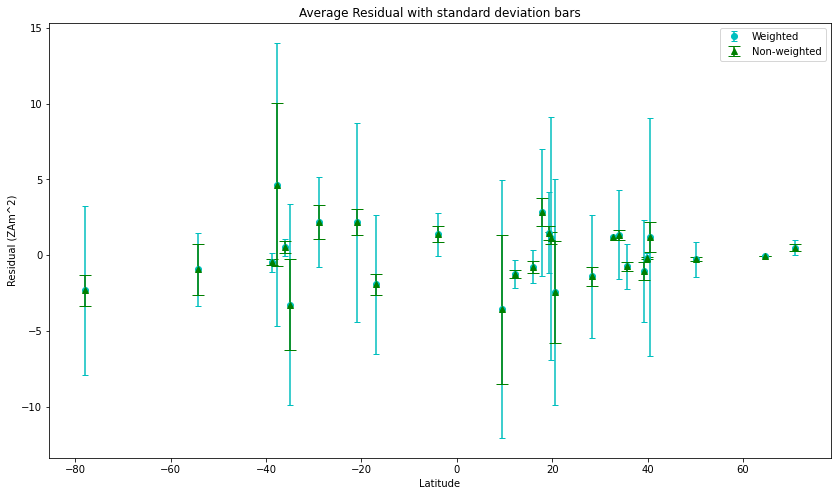

In [41]:
plt.figure(figsize=(14, 8))

# plot residual w stdv bars for nw and w stdv vs lat
residual_stdv_w = residual/pint05ma_groups_W_res["VADMCalc_stdv_w"] 
plt.errorbar(avglats, residual, yerr = residual_stdv_w, fmt = 'oc', capsize=3, label='Weighted')
plt.errorbar(avglats, residual, yerr = residual_stdv_nw, fmt = '^g', capsize=6, label='Non-weighted');

plt.xlabel('Latitude')
plt.ylabel('Residual (ZAm^2)') 
plt.title('Average Residual with standard deviation bars')
plt.legend();

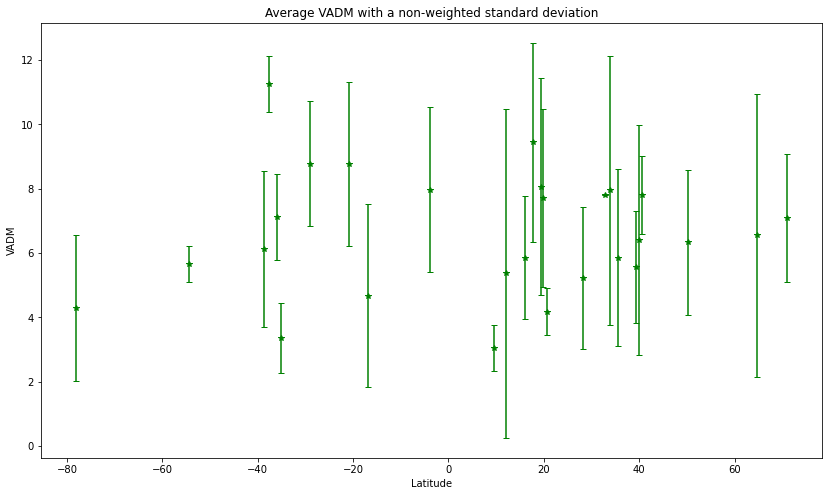

In [43]:
plt.figure(figsize=(14, 8))

plt.xlabel('Latitude')
plt.ylabel('VADM') 
plt.title('Average VADM with a non-weighted standard deviation')

avgvadm = pint05ma_groups['VADMCalc_avg'] 
plt.errorbar(avglats, avgvadm, yerr = pint05ma_groups['VADMCalc_stdv_nw'], fmt = '*g', capsize=3, label='Weighted');


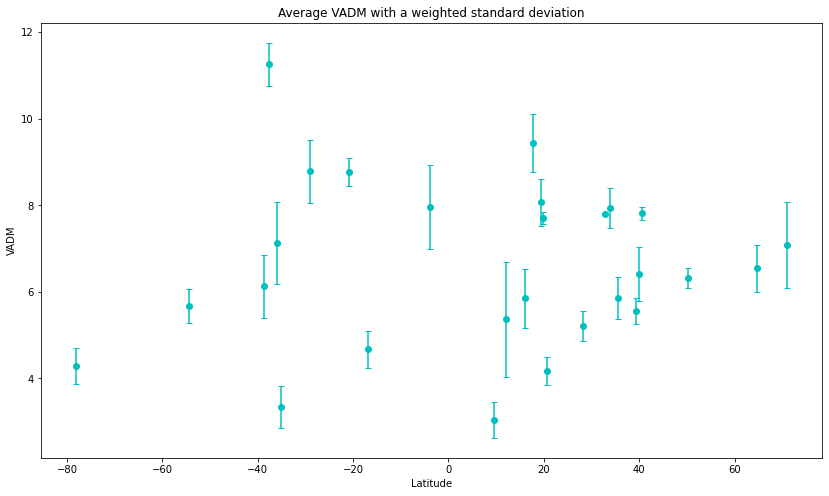

In [44]:
avgvadm = pint05ma_groups.VADMCalc_avg.values

plt.figure(figsize=(14, 8))

plt.xlabel('Latitude')
plt.ylabel('VADM') 
plt.title('Average VADM with a weighted standard deviation')

plt.errorbar(avglats, avgvadm, yerr = pint05ma_groups['VADMCalc_stdv_w'], fmt = 'oc', capsize=3, label='Weighted');
